# Introduction to basic E-Utilities functions using BioPython.

This notebook is modified from a notebook made during one of NCBI's Hackathons located on GitHub [here]('https://github.com/NCBI-Hackathons/NCBI_Jupyter/blob/master/NoteBooks/E-Utilities%20Quick%20Start%20with%20BioPython%20examples.ipynb')

The BioPython package documentation can be found [here]('https://biopython.org/wiki/Documentation').  Specifically, we are using the [Entrez module]('https://biopython.org/DIST/docs/api/Bio.Entrez-module.html').

To see much more documentation and example use cases, please take a look at the [Biopython tutorial and cookbook]('http://biopython.org/DIST/docs/tutorial/Tutorial.html')

We first need to install Biopython, the Python package that contains access to NCBI's Entrez Utilities (E-Utilities).  In this case on this machine we are using a Python 3.6 environment using an Anaconda distribution.  For regular python distributions, use `pip install biopython`

In [1]:
# using a an anaconda distribution
#!conda # create a new conda virtual environment
#!conda # activate new environment
#!conda install biopython # get biopython

In [2]:
from Bio import Entrez as EU
# set email for E-Utils calls (default is not set).
EU.email = 'ncbi_booth@ascb.org'
# set tool parameter (default is biopython).
EU.tool = 'e_utils_examples'
# set API key - providing one allows 10 requests per second, otherwise 3 request per second (optional)
EU.api_key = ''

## EInfo
Provides field index term counts, last update, and available links for each database.

Example: If no database parameter is supplied, einfo will return a list of all valid Entrez databases.

In [3]:
handle = EU.einfo()
db_info = EU.read(handle)
handle.close()
db_list = db_info["DbList"]
for db in db_list:
    print(db)

pubmed
protein
nuccore
ipg
nucleotide
nucgss
nucest
structure
sparcle
genome
annotinfo
assembly
bioproject
biosample
blastdbinfo
books
cdd
clinvar
clone
gap
gapplus
grasp
dbvar
gene
gds
geoprofiles
homologene
medgen
mesh
ncbisearch
nlmcatalog
omim
orgtrack
pmc
popset
probe
proteinclusters
pcassay
biosystems
pccompound
pcsubstance
seqannot
snp
sra
taxonomy
biocollections
unigene
gencoll
gtr


Example: Find database statistics from popular Entrez databases.

In [4]:
from time import sleep # using this to add delays in E-Utitlies calls to comply with NCBI policy

databases = ['gene', 'nuccore', 'protein', 'pubmed', 'pmc']
counts = [] # save counts in a list to use for plotting later
for db in databases:
    handle = EU.einfo(db=db)
    db_info = EU.read(handle)
    handle.close()
    dbInfo = db_info['DbInfo']
    counts.append(int(dbInfo['Count']))
    print('DB: ' + dbInfo['MenuName'] + ' - ' + dbInfo['Count'] + ' - ' + dbInfo['DbBuild'])
    sleep(0.5) # prevents more than 2 https requests per second

DB: Gene - 33754640 - Build181207-0240m.1
DB: Nucleotide - 272775112 - Build181208-2315m.1
DB: Protein - 614229719 - Build181207-1736m.1
DB: PubMed - 29155232 - Build181206-2212m.2
DB: PMC - 5354715 - Build181211-0105m.1


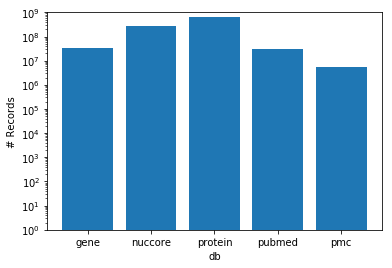

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# new figure and subplot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(databases, counts)
ax.set_yscale('log')
ax.set_xlabel('db')
ax.set_ylabel('# Records')
ax.set_ylim(1, 1e9)
plt.show()

## ESearch

Searches and retrieves primary IDs (for use in EFetch, ELink, and ESummary); optionally retains results for future use in the user's environment by storing an environment variable on a NCBI history server.

Example: search Entrez pubmed for breast cancer articles published in Science during 2008.

In [6]:
db = 'pubmed'
query = 'science[journal] AND breast cancer AND 2008[pdat]'

handle = EU.esearch(db, query, useHistory=True)
search_results = EU.read(handle)
handle.close()

E-Utilities uses a history server to store a search result - you need to reference both the query key and the web environment to access the search results

In [7]:
print('QueryKey: ' + search_results['QueryKey'])
print('WebEnv: ' + search_results['WebEnv'])
print('Found %s Pubmed IDs: [%s]' % (search_results['Count'], ', '.join(search_results['IdList'])))

QueryKey: 1
WebEnv: NCID_1_29063930_130.14.18.125_9001_1544566725_1583302526_0MetA0_S_MegaStore
Found 6 Pubmed IDs: [19008416, 18927361, 18787170, 18487186, 18239126, 18239125]


Example: Plot publications containing breast cancer MeSH terms over time

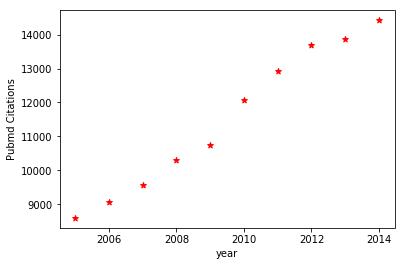

In [8]:
from time import sleep
years = range(2005, 2015, 1)
db = 'pubmed'
counts = []
for year in years:
    query = 'breast cancer[mesh] AND ' + str(year) + '[pdat]'
    handle = EU.esearch(db, query, useHistory=True)
    search_results = EU.read(handle)
    handle.close()
    counts.append(int(search_results['Count']))
    sleep(0.5) # again adding delay to not trigger API limit
plt.scatter(years, counts, marker='*', color='red')
plt.xlabel('year')
plt.ylabel('Pubmd Citations')
plt.show()

## ESummary

Retrieves document summaries from a list of primary IDs or from the user's environment.
Example: retrieve summaries and display titles

In [9]:
db = 'pubmed'
handle = EU.esummary(db=db, id=','.join(search_results['IdList']))
summaries = EU.read(handle)
handle.close()

for pmid, title in zip([summary['Id'] for summary in summaries], [summary['Title'] for summary in summaries]):
    print(pmid + ': ' + title)

27591470: Awake insertion of a Laryngeal Mask Airway-Proseal™ as alternative to awake fiberoptic intubation in management of anticipated difficult airway in ambulatory surgery.
27357923: When the treatment stops: A qualitative study of life post breast cancer treatment.
26629941: Overexpression of SMAR1 Enhances Radiosensitivity in Human Breast Cancer Cell Line MCF7 via Activation of p53 Signaling Pathway.
26592223: Characterization of chronic pain in breast cancer survivors using the McGill Pain Questionnaire.
26576798: Spontaneous regression of breast angiosarcoma after conservative treatment with radiotherapy: a case report and review of the literature.
26557471: Barriers and facilitators to recruitment to a culturally-based dietary intervention among urban Hispanic breast cancer survivors.
26357040: Network-Based Methods to Identify Highly Discriminating Subsets of Biomarkers.
26351208: Combined Use of Metformin and Everolimus Is Synergistic in the Treatment of Breast Cancer Cells.

In [10]:
# you can explore that the data fields look like by unpacking the list of dictionaries
for item in summaries:
    for key, value in item.items():
        print(key + ': ' + str(value))

Item: []
Id: 27591470
PubDate: 2016 Sep-Oct
EPubDate: 2014 May 1
Source: Braz J Anesthesiol
AuthorList: ['Zaballos M', 'Ginel MD', 'Portas M', 'Barrio M', 'López AM']
LastAuthor: López AM
Title: Awake insertion of a Laryngeal Mask Airway-Proseal™ as alternative to awake fiberoptic intubation in management of anticipated difficult airway in ambulatory surgery.
Volume: 66
Issue: 5
Pages: 539-42
LangList: ['English']
NlmUniqueID: 101624623
ISSN: 
ESSN: 0104-0014
PubTypeList: ['Journal Article']
RecordStatus: PubMed - indexed for MEDLINE
PubStatus: ppublish+epublish
ArticleIds: DictElement({'pubmed': ['27591470'], 'medline': [], 'pii': 'S0104-0014(14)00062-1', 'doi': '10.1016/j.bjane.2014.03.007', 'rid': '27591470', 'eid': '27591470'}, attributes={})
DOI: 10.1016/j.bjane.2014.03.007
History: DictElement({'pubmed': ['2016/09/04 06:00'], 'medline': ['2017/04/15 06:00'], 'received': '2014/02/24 00:00', 'accepted': '2014/03/19 00:00', 'entrez': '2016/09/04 06:00'}, attributes={})
References: [

## ELink
Checks for the existence of an external or Related Articles link from a list of one or more primary IDs. 
Retrieves primary IDs and relevancy scores for links to Entrez databases or Related Articles; creates a hyperlink to the primary LinkOut provider for a specific ID and database, or lists LinkOut URLs and Attributes for multiple IDs.

Example: Find related items related to initial article (PMID:19008416)

In [11]:
db = 'pubmed'
id = 19008416
handle = EU.elink(db=db, id=id)
for linkset in EU.read(handle):
    linkset_db = linkset['LinkSetDb']
    for link in linkset_db:
         print('%s has %d links ' % (link['LinkName'], len(link['Link'])))
handle.close()

pubmed_pubmed has 280 links 
pubmed_pubmed_alsoviewed has 17 links 
pubmed_pubmed_citedin has 355 links 
pubmed_pubmed_combined has 6 links 
pubmed_pubmed_five has 6 links 
pubmed_pubmed_refs has 25 links 
pubmed_pubmed_reviews has 35 links 
pubmed_pubmed_reviews_five has 6 links 


## EFetch
Retrieves records in the requested format from a list of one or more primary IDs or from the user's environment

In [12]:
db = 'nuccore'
return_type = 'fasta'
query = 'NM_001126.3'
number_of_rows_to_display = 10

handle = EU.esearch(db=db, term=query)
search_results = EU.read(handle)
handle.close()

fasta = EU.efetch(db=db, id=search_results['IdList'], rettype=return_type)
data = fasta.read().splitlines()
print('Using an ID List')
print("Showing %s of %s lines" % (number_of_rows_to_display, len(data)))
for line in data[:number_of_rows_to_display]:
    print(line)

Using an ID List
Showing 10 of 42 lines
>NM_001126.3 Homo sapiens adenylosuccinate synthase (ADSS), mRNA
ACGGGAGTGGCGCGCCAGGCCGCGGAAGGGGCGTGGCCTCGGTCCGGGGTGGCGGCCGTTGCCGCCACCA
GGGCCTCTTCCTGCGGGCGGTGCTGCCGAGGCCGGCCTGCGCGGGGCAGTCATGGTACCCCCTTGAGCGG
GCTGTGGCGGAGAGCGGGGCGGGGACTGGCTGGAGGGTGGCGGCCCGGCGGGGCGGGGGCGGGGCCGGCC
TCTGGCTCCTTCTTCCTCTGCATGTGGCTGGCGGCCGCAGAGCAGTTCAGTTCGCTCACTCCTCGCCGGC
CGCCTCTCCTTCGGGCTCTCCTCGCGTCACTGGAGCCATGGCGTTCGCCGAGACCTACCCGGCGGCATCC
TCCCTGCCCAACGGCGATTGCGGCCGCCCCAGGGCGCGGCCCGGAGGAAACCGGGTGACGGTGGTGCTCG
GTGCGCAGTGGGGCGACGAAGGCAAAGGGAAGGTGGTGGACCTGCTGGCGCAGGACGCCGACATCGTGTG
CCGCTGCCAGGGAGGAAATAATGCTGGCCATACAGTTGTTGTGGATTCTGTGGAATATGATTTTCATCTC
TTACCCAGTGGAATAATTAATCCAAATGTCACTGCATTCATTGGAAATGGTGTGGTAATTCATCTACCTG


In [13]:
# Combining E-Search and E-Fetch Using the History Server
db = 'pubmed'
query = 'science[journal] AND 2015[pdat]'
handle = EU.esearch(db, query, useHistory=True)
search_results = EU.read(handle)
handle.close()
query_key = search_results['QueryKey']
webEnv = search_results['WebEnv']
return_type = 'text'
abstracts = EU.efetch(db, WebEnv=webEnv, query_key=query_key, return_type='text')

# when stored as text by using the read function, we can perform string methods
# such as counting the number of times the term cancer appears in these abstracts
data = abstracts.read()
data.count('cancer')

132

In [14]:
# we can also save the text directly to file
abstracts = EU.efetch(db='pubmed', WebEnv=webEnv, query_key=query_key, return_type='text')
lines = abstracts.readlines()
f = open('out.txt', 'w')
for line in lines:
    f.write(line)
f.close()

## EGquery
Provides Entrez database counts for a single search using Global Query. (https://www.ncbi.nlm.nih.gov/search)

In [15]:
query = 'NM_001126.3'

handle = EU.egquery(term=query)
results = EU.read(handle)

output = [r for r in results['eGQueryResult'] if r['Count'] != "0"]
for result in output:
    print(result['DbName'] + ' found ' + result['Count'] + ' results')

snp found 10236 results
unigene found 1 results
homologene found 1 results


## ESpell
Retrieves spelling suggestions.

In [16]:
query = 'geene transxript protien'
handle = EU.espell(term=query)
corrected = EU.read(handle)
print(corrected['CorrectedQuery'])

gene transcript protein


## ECitmatch
Retrieves PubMed IDs (PMIDs) that correspond to a set of input citation strings.

Example: retrieve PMID for multiple citations, and display their titles.

In [17]:
db = 'pubmed'
citations = [{"journal_title": "proc natl acad sci u s a", "x": 1, "year": "1991", "author_name": "mann bj", "key": "citation_1"},
             {"journal_title": "PLoS One", "year": "2012", "author_name": "haro kj" }]

handle = EU.ecitmatch(db=db, bdata=citations)

handle_read = handle.read().strip().split('\n')
results = [i.split("|") for i in handle_read]

for result in results:
    print(result)
    print(EU.read(EU.esummary(db=db, id=result[6]))[0]['Title'])

['proc natl acad sci u s a', '1991', '', '', 'mann bj', 'citation_1', '2014248']
Sequence of a cysteine-rich galactose-specific lectin of Entamoeba histolytica.
['PLoS One', '2012', '', '', 'haro kj', '', '23155415']
Dysregulation of IRP1-mediated iron metabolism causes gamma ray-specific radioresistance in leukemia cells.


## EPost
Posts a file containing a list of primary IDs for future use in the user's environment to use with subsequent data retrieval

Example: upload a list nuccore ids and retrieve summaries and sequences

In [18]:
db = 'nuccore'
ids = ['MH011443.1', 'MH366483.1']
rettype = 'fasta'
number_of_rows_to_display = 20

handle = EU.epost(db=db, id=','.join(ids))
env = EU.read(handle)
handle2 = EU.esummary(db=db, query_key=env['QueryKey'], WebEnv=env['WebEnv'])

summaries = handle2.read()
handle.close()
print(summaries)

# use EFetch to fetch the sequence data in FASTA format
print('\nSequence Data:\n')
fetch = EU.efetch(db=db, rettype=rettype, query_key=env['QueryKey'], WebEnv=env['WebEnv'])
data = fetch.read().splitlines()
print("Showing %s of %s lines" % (number_of_rows_to_display, len(data)))
for line in data[:number_of_rows_to_display]:
    print(line)
fetch.close()

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSummaryResult PUBLIC "-//NLM//DTD esummary v1 20041029//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20041029/esummary-v1.dtd">
<eSummaryResult>
<DocSum>
	<Id>1486783306</Id>
	<Item Name="Caption" Type="String">MH011443</Item>
	<Item Name="Title" Type="String">Homo sapiens TP53 (TP53) gene, exon 5 and partial cds</Item>
	<Item Name="Extra" Type="String">gi|1486783306|gb|MH011443.1|[1486783306]</Item>
	<Item Name="Gi" Type="Integer">1486783306</Item>
	<Item Name="CreateDate" Type="String">2018/10/09</Item>
	<Item Name="UpdateDate" Type="String">2018/10/09</Item>
	<Item Name="Flags" Type="Integer">0</Item>
	<Item Name="TaxId" Type="Integer">9606</Item>
	<Item Name="Length" Type="Integer">123</Item>
	<Item Name="Status" Type="String">live</Item>
	<Item Name="ReplacedBy" Type="String"></Item>
	<Item Name="Comment" Type="String"><![CDATA[  ]]></Item>
	<Item Name="AccessionVersion" Type="String">MH011443.1</Item>
</DocSum>

<DocSum>
	<Id>